In [1]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [2]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [3]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

In [4]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

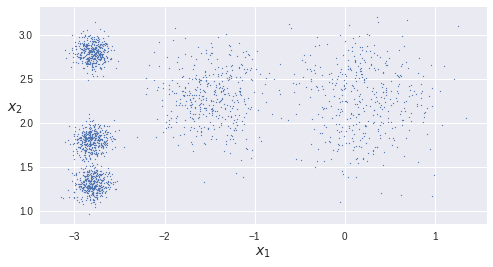

In [5]:
plt.figure(figsize=(8, 4))
plot_clusters(X)

In [6]:
from sklearn.cluster import KMeans

In [7]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters)
y_pred = kmeans.fit_predict(X, y)

In [8]:
# predicted values are stored in kmeans.labels_
y_pred, y_pred is kmeans.labels_

(array([4, 0, 1, ..., 3, 1, 0], dtype=int32), True)

In [9]:
# these are the centroids found by the kmeans algorithms
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-1.46679593,  2.28585348],
       [-2.79290307,  2.79641063],
       [-2.80037642,  1.30082566]])

In [10]:
# predicting new instances 
X_new = np.array([[0, 2], [-3, 2]])
kmeans.predict(X_new)

array([1, 0], dtype=int32)

### FINDING THE OPTIMAL NUMBER OF CLUSTERS - ELBOW METHOD

In [11]:
inertias = []

for i in range(2, 10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X, y)
    inertias.append(kmeans.inertia_)

print(inertias)

[1149.6140723750277, 653.2167190021553, 261.79677785694696, 211.5985372581684, 169.2213309095289, 141.38336489568496, 119.08491834735284, 102.53319403706952]


In [12]:
def plot_elbow(inertias):
    plt.plot(range(2, len(inertias) + 2), inertias)
    plt.xlabel('n_clusters')
    plt.ylabel('inertia')

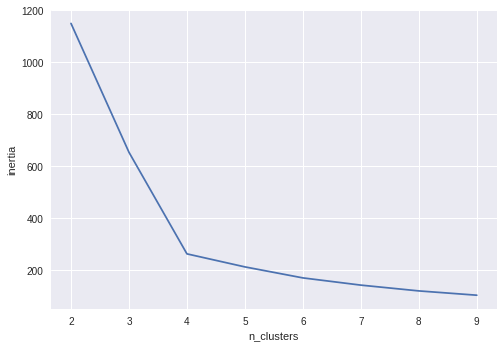

In [13]:
plot_elbow(inertias);

# seems like 4 (or 5) is the optimal number of clusters

In [14]:
from sklearn.metrics import silhouette_score

In [15]:
sil_scores = []

for i in range(2, 10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X, y)
    sil_scores.append(silhouette_score(X, kmeans.labels_))

In [16]:
def plot_silhouette(scores):
    plt.plot(range(2, len(scores) + 2), scores)

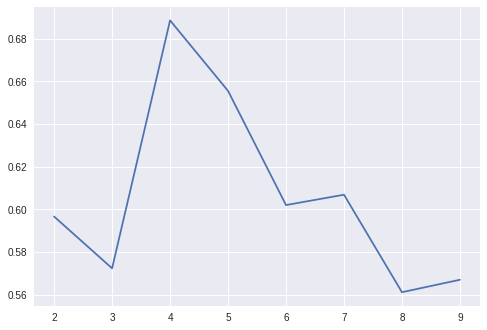

In [17]:
plot_silhouette(sil_scores);
# it is clearer that the 5 clusters is also a valid option from this graph

# USING CLUSTERING FOR PREPROCESSING

In [18]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)

0


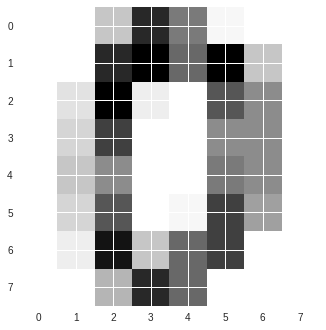

In [19]:
plt.imshow(X_digits[0].reshape((8, 8)));
print(y_digits[0])

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, 
                                                    test_size=0.2, random_state=42)

In [21]:
from sklearn.linear_model import LogisticRegression

In [22]:
clf = LogisticRegression()
clf.fit(X_train, y_train);

/home/matus/documents/machine_learning/venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [23]:
clf.score(X_test, y_test)

0.9694444444444444

In [24]:
from sklearn.pipeline import Pipeline

In [25]:
# kmeans will replace images of digits with their distances these clusters
pipeline = Pipeline([
    ('kmeans', KMeans(n_clusters=50)), 
    ('log_reg', LogisticRegression())
])

pipeline.fit(X_train, y_train);

/home/matus/documents/machine_learning/venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [26]:
pipeline.score(X_test, y_test)

0.975

In [27]:
# searching for better number of clusters using grid search
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'kmeans__n_clusters': range(2, 200, 10)
    }
]

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, 
                           n_jobs=-1, scoring='accuracy')

grid_search.fit(X_train, y_train);

/home/matus/documents/machine_learning/venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [28]:
grid_search.best_params_

{'kmeans__n_clusters': 192}

In [29]:
grid_search.score(X_test, y_test)

0.975

## CLUSTERING FOR SEMI-SUPERVISED LEARNING

In [30]:
# pick n_clusters (50)
# compute distances between each instance and each cluster 
# pick one representative instance for each cluster (one with the lowest distance) 
#   => label this instance manually
# use the representative instances for training

In [36]:
# first, let's try picking 50 random instances 
n_labeled = 50

clf = LogisticRegression()
clf.fit(X_train[:n_labeled], y_train[:n_labeled])
clf.score(X_test, y_test)

/home/matus/documents/machine_learning/venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8277777777777777

In [37]:
# let's pick the representative instances
kmeans = KMeans(n_clusters=50)
X_instances_dist = kmeans.fit_transform(X_train)
X_instances_dist.shape

(1437, 50)

In [38]:
representative_instances_idx = np.argmin(X_instances_dist, axis=0)
representative_instances_idx

array([  24,  508, 1401,  700,  501, 1147,  295,  532,  773,  571,  856,
        951, 1150,  981,   38,  447,  649,   37,  792,  784, 1112,  952,
        843,  346,  663,  513,  265,  866,  249,  163,  241, 1301,   78,
         13,  945,  193,  680, 1095,  678,  587,  749,  384,  917,  885,
       1194, 1404,  625,  827, 1156, 1284])

In [46]:
representative_instances = X_train[representative_instances_idx]
representative_instances.shape
# now we have 50 representative instances (8x8 images)

(50, 64)

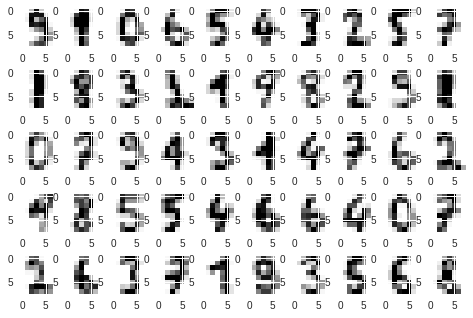

In [62]:
fig, ax = plt.subplots(nrows=5, ncols=10)
for i in range(50):
    row = i // 10
    col = i % 10
    ax[row][col].imshow(representative_instances[i].reshape((8, 8)))

In [127]:
# create labels manually 
y_representative_instances = np.array([9, 1, 0, 6, 5, 4, 3, 2, 5, 7,
                                       1, 8, 3, 1, 1, 9, 8, 2, 9, 1,
                                       0, 7, 9, 4, 3, 1, 4, 7, 6, 2,
                                       9, 8, 5, 5, 4, 6, 6, 4, 0, 7,
                                       2, 6, 3, 7, 1, 9, 3, 5, 6, 8])

In [128]:
clf = LogisticRegression()
clf.fit(representative_instances, y_representative_instances);

/home/matus/documents/machine_learning/venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [130]:
clf.score(X_test, y_test)
# we were able to increase accurace by almost 10 percent using the same amount of instances

0.9083333333333333

# GAUSSIAN MIXTURE

In [131]:

X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [132]:
from sklearn.mixture import GaussianMixture

In [135]:
# n_init=10 => gaussian mixture can suffer from poor choice of clusters, in the same way
# as KMeans, therefore we need to run it multiple times, and then keep the best one
gm = GaussianMixture(n_components=3, n_init=10)
gm.fit(X);

In [136]:
gm.weights_

array([0.39065109, 0.40009697, 0.20925194])

In [137]:
gm.means_

array([[ 0.05292802,  0.07720061],
       [-1.40745226,  1.42727761],
       [ 3.40241777,  1.05702687]])

In [138]:
gm.covariances_

array([[[ 0.69052478,  0.79895376],
        [ 0.79895376,  1.21568342]],

       [[ 0.63518782,  0.7300408 ],
        [ 0.7300408 ,  1.16123726]],

       [[ 1.14357415, -0.02922398],
        [-0.02922398,  0.95297095]]])

In [139]:
gm.converged_
# algorithm has converged

True

In [140]:
# it took 6 iteration to converge
gm.n_iter_

6

In [141]:
# we can predict instance's assignment by using either hard or soft classtering
gm.predict(X) # hard clustering

array([0, 0, 1, ..., 2, 2, 2])

In [142]:
gm.predict_proba(X) # soft clustering

array([[9.77270907e-01, 6.80542526e-07, 2.27284124e-02],
       [9.83281876e-01, 6.78281758e-04, 1.60398423e-02],
       [7.51931764e-05, 9.99922872e-01, 1.93447944e-06],
       ...,
       [4.39240952e-07, 2.19704604e-26, 9.99999561e-01],
       [5.39200212e-16, 1.52817376e-41, 1.00000000e+00],
       [2.33864674e-15, 8.29296554e-41, 1.00000000e+00]])

In [147]:
# gaussian mixtures is a generating algorithm => it can be used to generate new instances
X_new, y_new = gm.sample(6)

In [148]:
X_new

array([[-1.36427837, -1.46356773],
       [ 2.15640567,  2.06953337],
       [-0.36407385,  2.34993403],
       [-1.6148198 ,  1.6540144 ],
       [-1.82726502,  0.73349747],
       [ 2.75453455,  0.28724448]])

In [149]:
y_new

array([0, 0, 1, 1, 1, 2])

# KMEANS (olivetti faces)

In [150]:
from sklearn.datasets import fetch_olivetti_faces

In [160]:
faces = fetch_olivetti_faces()
X, y = faces['data'], faces['target']
images = faces['images']

In [158]:
X.shape, y.shape

((400, 4096), (400,))

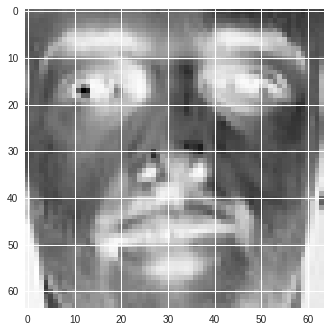

In [170]:
plt.imshow(images[150]);

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [176]:
inertias = []
for i in range(2, 20):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X_train)
    inertias.append(kmeans.inertia_)

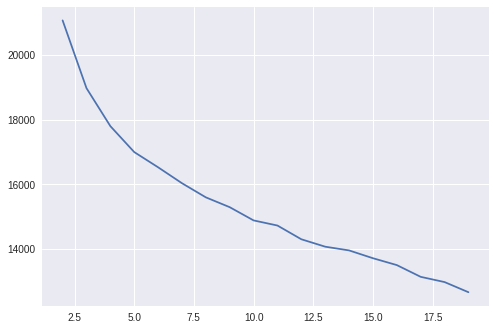

In [177]:
plt.plot(range(2, 20), inertias);
# maybe 5?

In [182]:
sil_scores = []
for i in range(2, 20):
    kmeans = KMeans(n_clusters=i)
    y_pred = kmeans.fit(X_train)
    sil_scores.append(silhouette_score(X_train, kmeans.labels_))

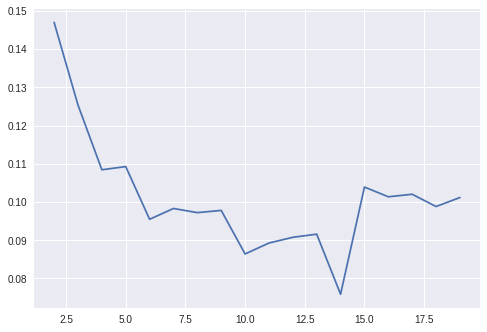

In [185]:
plt.plot(range(2, 20), sil_scores);

In [218]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

clf = RandomForestClassifier(max_depth=30)
clf.fit(X_train, y_train);

In [219]:
y_test_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)

print(f'f1 score (train): {f1_score(y_train, y_train_pred, average="macro")}')
print(f'f1 score (test) : {f1_score(y_test, y_test_pred, average="macro")}')

f1 score (train): 1.0
f1 score (test) : 0.9220458553791886


In [221]:
# training random forest on the reduced dataset
pipeline = Pipeline([
    ('kmeans', KMeans(n_clusters=5)),
    ('forest_clf', RandomForestClassifier(max_depth=30))
])

pipeline.fit(X_train, y_train);

In [223]:
y_test_pred = pipeline.predict(X_test)
y_train_pred = pipeline.predict(X_train)

print(f'f1 score (train): {f1_score(y_train, y_train_pred, average="macro")}')
print(f'f1 score (test) : {f1_score(y_test, y_test_pred, average="macro")}')

f1 score (train): 1.0
f1 score (test) : 0.5289880952380952


In [224]:
param_grid = [
    {
        'kmeans__n_clusters': range(2, 50, 2)
    }
]

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, 
                           scoring='accuracy', n_jobs=-1, cv=3)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kmeans',
                                        KMeans(algorithm='auto', copy_x=True,
                                               init='k-means++', max_iter=300,
                                               n_clusters=5, n_init=10,
                                               n_jobs=None,
                                               precompute_distances='auto',
                                               random_state=None, tol=0.0001,
                                               verbose=0)),
                                       ('forest_clf',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion=

In [225]:
grid_search.best_params_

{'kmeans__n_clusters': 42}

In [232]:
y_test_pred = grid_search.predict(X_test)
y_train_pred = grid_search.predict(X_train)

print(f'f1 score (train): {f1_score(y_train, y_train_pred, average="macro")}')
print(f'f1 score (test) : {f1_score(y_test, y_test_pred, average="macro")}')
# using K-means to reduce the dataset resulted in poorer performance in this case

f1 score (train): 1.0
f1 score (test) : 0.7719184324447483


# Image sampling with GaussianMixture

In [292]:
from sklearn.decomposition import PCA
# preprocessing dataset with PCA to speed the process
pca = PCA(n_components=225)
pca.fit(X_train);

In [294]:
X_reduced = pca.fit_transform(X_train)

In [296]:
sample = pca.inverse_transform([X_reduced[0]])

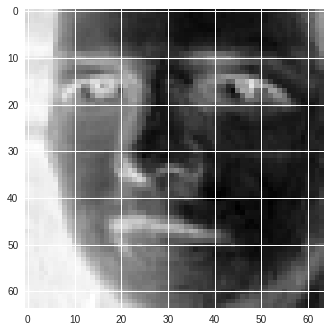

In [302]:
plt.imshow(sample.reshape((64, 64)));

In [334]:
bic_aic = []
for i in range(1, 10):
    gm = GaussianMixture(n_components=i)
    gm.fit(X_train)
    bic = gm.bic(X_train)
    aic = gm.bic(X_train)
    bic_aic.append((bic, aic))

[(33899381.1346045, 33899381.1346045),
 (81861145.09390171, 81861145.09390171),
 (130033803.18304403, 130033803.18304403),
 (178345639.29514766, 178345639.29514766),
 (226705290.3456705, 226705290.3456705),
 (275090943.0408469, 275090943.0408469),
 (323481876.284048, 323481876.284048),
 (371892849.82614434, 371892849.82614434),
 (420310889.6637895, 420310889.6637895)]

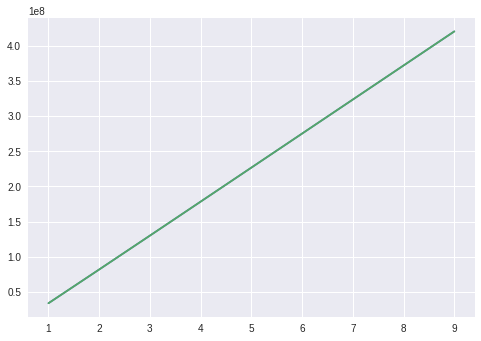

In [339]:
plt.plot(range(1, 10), [x[0] for x in bic_aic])
plt.plot(range(1, 10), [x[1] for x in bic_aic])
plt.show()

In [378]:
gm = GaussianMixture(n_components=50)
gm.fit(X_reduced)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=50, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [393]:
gm_sample = gm.sample(1)

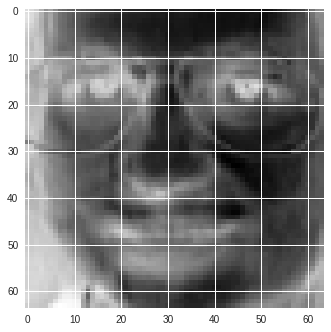

In [394]:
plt.imshow(pca.inverse_transform(gm_sample[0]).reshape((64, 64)));